## Time to get your hands dirty! Supernova distances and redshifts (part 2)
First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z)^3+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it, are you frequentist or Bayesian after all?).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

In [1]:
from astroML.datasets import generate_mu_z
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from astropy.cosmology import LambdaCDM
from scipy.integrate import quad
import scipy.stats
import emcee
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import corner
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity

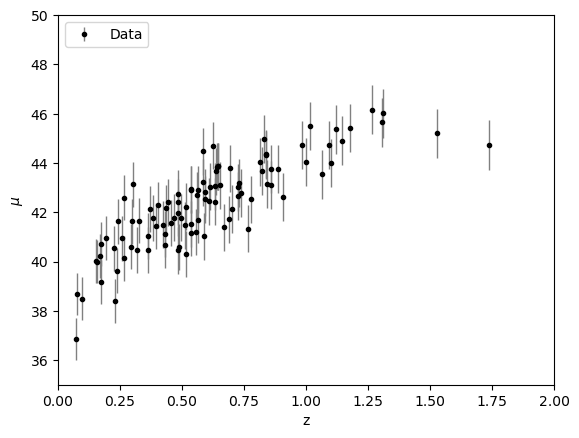

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)  #Generating the data with their errors

#Scatter plot of the data
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [3]:
z_grid = np.linspace(0.05, 2., 1000)

## GPR

In [4]:
kernel = ConstantKernel() * RBF()  #Defining the kernel (the kernel specifying the covariance function of the GP)
gp = GaussianProcessRegressor(kernel=kernel, alpha = dmu**2)  #Alpha is the value added to the diagonal of the kernel matrix during fitting
gp.fit(z_sample[:, np.newaxis], mu_sample)  #Fitting the data

GaussianProcessRegressor(alpha=array([0.84387183, 0.91812087, 0.89001003, 0.94522717, 0.94422381,
       0.86154897, 0.86230499, 0.94838417, 0.9933467 , 0.9646779 ,
       0.87701523, 0.89976228, 0.92772472, 0.93248803, 0.87910942,
       0.90886653, 0.90007965, 0.74796941, 0.94290888, 0.96641079,
       0.87820976, 0.91709206, 0.80479835, 0.87887073, 0.98216481,
       0.92265029, 0.8835475 , 0.94586178, 0.86985...
       0.93684146, 0.91281498, 0.89527413, 0.81855684, 0.85259287,
       0.97119502, 0.88669278, 0.90504074, 0.72518962, 0.86689404,
       0.88987903, 0.91659546, 0.97685316, 0.91867826, 0.93138181,
       0.83270862, 0.93814442, 0.95430226, 0.9199094 , 0.89010136,
       0.83350663, 0.90995601, 0.90388843, 0.98995206, 0.89661359,
       0.90000008, 0.90519576, 0.95184399, 0.79454928, 0.92548723]),
                         kernel=1**2 * RBF(length_scale=1))

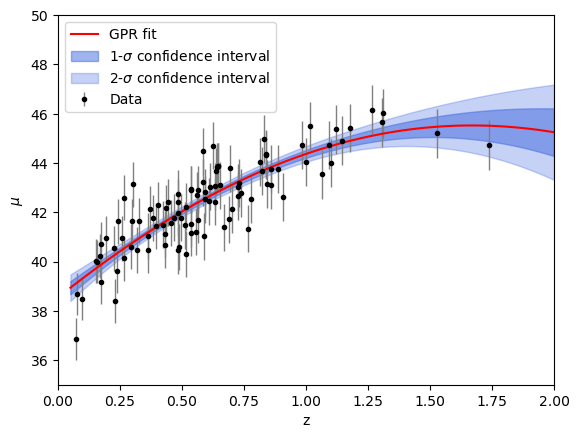

In [5]:
#Plotting the results
fit, fit_err = gp.predict(z_grid[:, np.newaxis], return_std=True)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.plot(z_grid, fit, color = 'red', label = 'GPR fit')
plt.fill_between(z_grid, fit+fit_err, fit-fit_err, color = 'royalblue', alpha = 0.5, label = r'1-$\sigma$ confidence interval')
plt.fill_between(z_grid, fit+2*fit_err, fit-2*fit_err, color = 'royalblue', alpha = 0.3, label = r'2-$\sigma$ confidence interval')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Parametric fit

In [6]:
H_min, H_max = 50, 100
omega_min, omega_max = 0.1, 1

theta_guess = [70, 0.27]  #Intial guess
labels = [r'$H_0$', r'$\Omega_{m}$']

In [7]:
#Defining the theoretical model
def model(z, theta):
    H, omega = theta
    cosmological = LambdaCDM(H0 = H, Om0 = omega, Ode0= 1-omega)
    return cosmological.distmod(z).value

#### MCMC

In [8]:
def Logprior_mcmc(theta):
    H, omega = theta 
    if H_min < H < H_max and omega_min < omega < omega_max:
        return 0.0
    return -np.inf

def LogLikelihood_mcmc(theta, z, mu):
    H, omega = theta
    if omega < 0:
        return -np.inf
    else:
        mu_fit = model(z, theta)
        return np.sum(scipy.stats.norm(loc=mu_fit, scale=dmu).logpdf(mu))

def LogPosterior_mcmc(theta, z, mu):
    if not np.isfinite(Logprior_mcmc(theta)):
        return - np.inf
    else:
        return LogLikelihood_mcmc(theta, z, mu) + Logprior_mcmc(theta)

In [9]:
ndim = 2  #Number of features
nwalkers = 10  
burn = 1000  
nsteps = 10000  

np.random.seed(42)
starting_guesses = theta_guess + np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior_mcmc, args=[z_sample, mu_sample])  #Defining the sampler
sampler.run_mcmc(starting_guesses, nsteps, progress = True)  #Running the sampler

emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)  #Burned trace

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\restu\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [03:23<00:00, 49.05it/s]


In [10]:
tau = sampler.get_autocorr_time()  #Computing the autocorrelation length
thin = tau.astype(int) + 1
print('Autocorrelation times:\n%f, %f' %(tau[0], tau[1]))

Autocorrelation times:
44.528802, 39.108348


In [11]:
burned_trace = sampler.get_chain(discard = 10*max(thin), thin=max(thin), flat=True)  #Thinning the chain

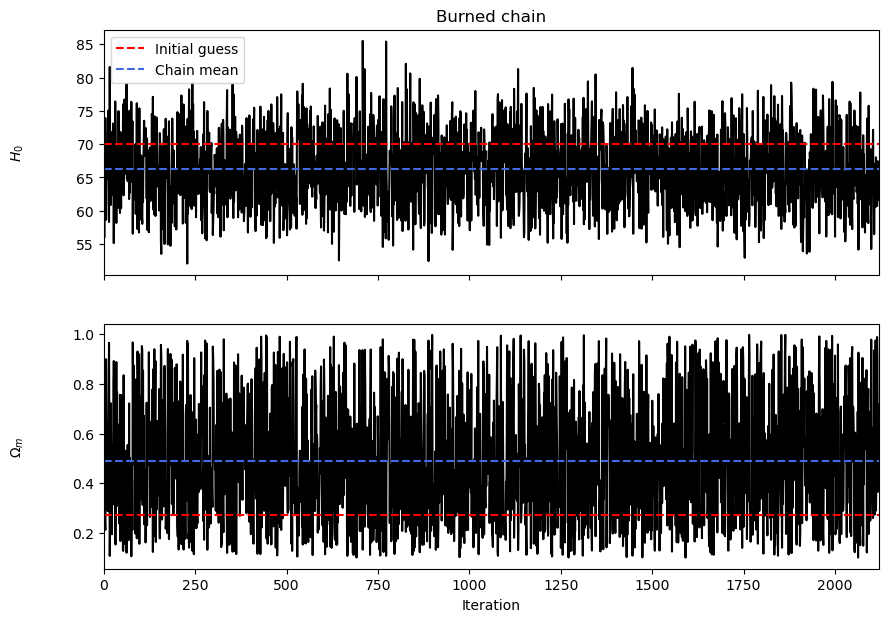

In [12]:
#Plot of the burned traces
fig1, axes1 = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(ndim):
    axes1[i].plot(burned_trace[:,i], color = 'black')
    axes1[i].axhline(theta_guess[i], color = 'red', ls = '--', label = 'Initial guess')
    axes1[i].axhline(np.mean(burned_trace[:, i]), color = 'royalblue', ls = '--', label='Chain mean')
    axes1[i].set_xlim(0, len(burned_trace))
    axes1[i].set_ylabel(labels[i])
    axes1[i].yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel('Iteration')
axes1[0].legend()
axes1[0].set_title('Burned chain')
plt.show()

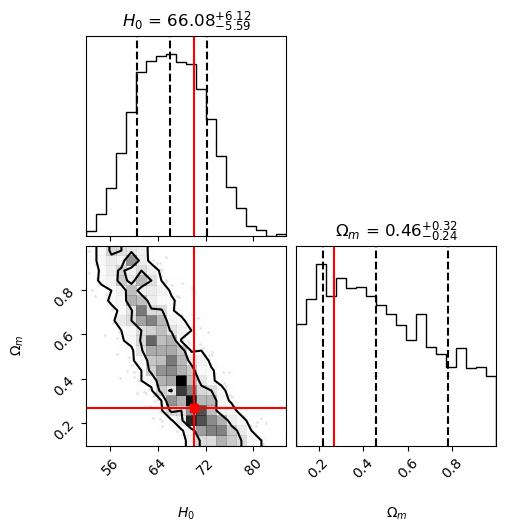

In [13]:
#Corner plot highlighting the initial guess
fig = corner.corner(burned_trace, labels=labels, levels=[0.68,0.95], show_titles=True, 
                    quantiles=[0.16, 0.5, 0.84], truths=theta_guess, truth_color='red');

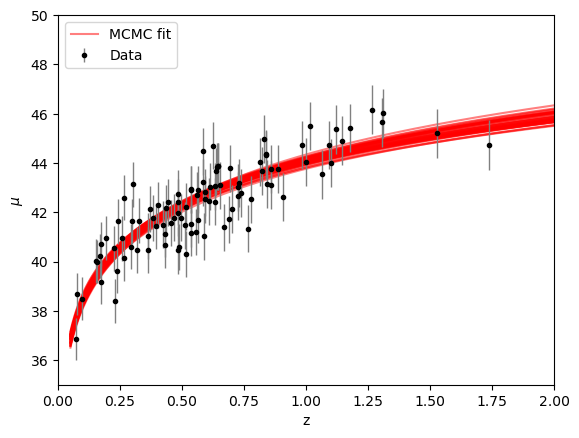

In [14]:
#Fitting our data using different values of parameters
theta_mcmc = burned_trace[::50,:]
for i in range(len(theta_mcmc[:, 0])):
    if i==0:
        plt.plot(z_grid, model(z_grid, theta_mcmc[i, :]), color = 'red', alpha=0.5, label = 'MCMC fit')
    else:
        plt.plot(z_grid, model(z_grid, theta_mcmc[i, :]), color = 'red', alpha=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

In [15]:
#Finding the MAP
log_probabilities = sampler.get_log_prob(discard = 10*max(thin), thin=max(thin), flat=True)
max_posterior = burned_trace[np.argmax(log_probabilities)]
print('Parameters that maximize the posterior: ', max_posterior)

Parameters that maximize the posterior:  [68.69703158  0.33842274]


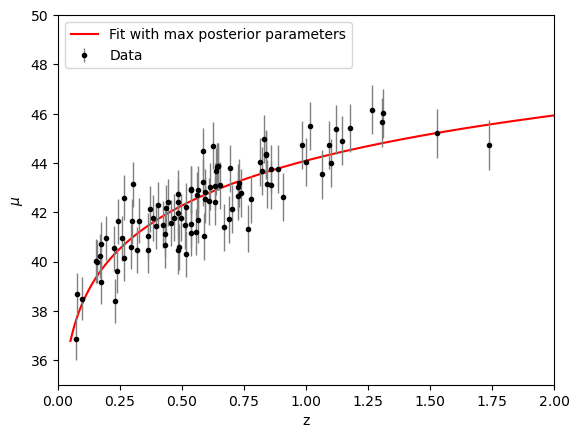

In [16]:
#Fitting our data using the MAP
plt.plot(z_grid, model(z_grid, max_posterior), color = 'red', label = 'Fit with max posterior parameters')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

#### Nested sampling

In [17]:
def LogLikelihood_nested(theta, z, mu):
    H, omega = theta
    if omega < 0:
        return -np.inf
    else:
        mu_fit = model(z, theta)
        return np.sum(scipy.stats.norm(loc=mu_fit, scale=dmu).logpdf(mu)) 

def Prior_nested(u):
    #Dynesty draws parameters from the unitary hypercube space,[0,1]^n, where n is the number of parameter. So we havo to transform u to obtain
    #our paramters of interest
    param = np.copy(u)
    #The next function computes the quantile function for a uniform distribution
    param[0] = scipy.stats.uniform.ppf(u[0], loc = H_min, scale = H_max-H_min)
    param[1] = scipy.stats.uniform.ppf(u[1], loc = omega_min, scale = omega_max-omega_min)
    return param

In [18]:
ndim = 2
nested = dynesty.NestedSampler(LogLikelihood_nested, Prior_nested, ndim, logl_args=[z_sample, mu_sample], nlive = 10000)  #Defining the sampler
nested.run_nested()  #Running the sampler
sresults = nested.results

8559it [00:38, 222.18it/s, +10000 | bound: 0 | nc: 1 | ncall: 33477 | eff(%): 79.052 | loglstar:   -inf < -132.814 <    inf | logz: -134.978 +/-    nan | dlogz:  0.000 > 10.009]


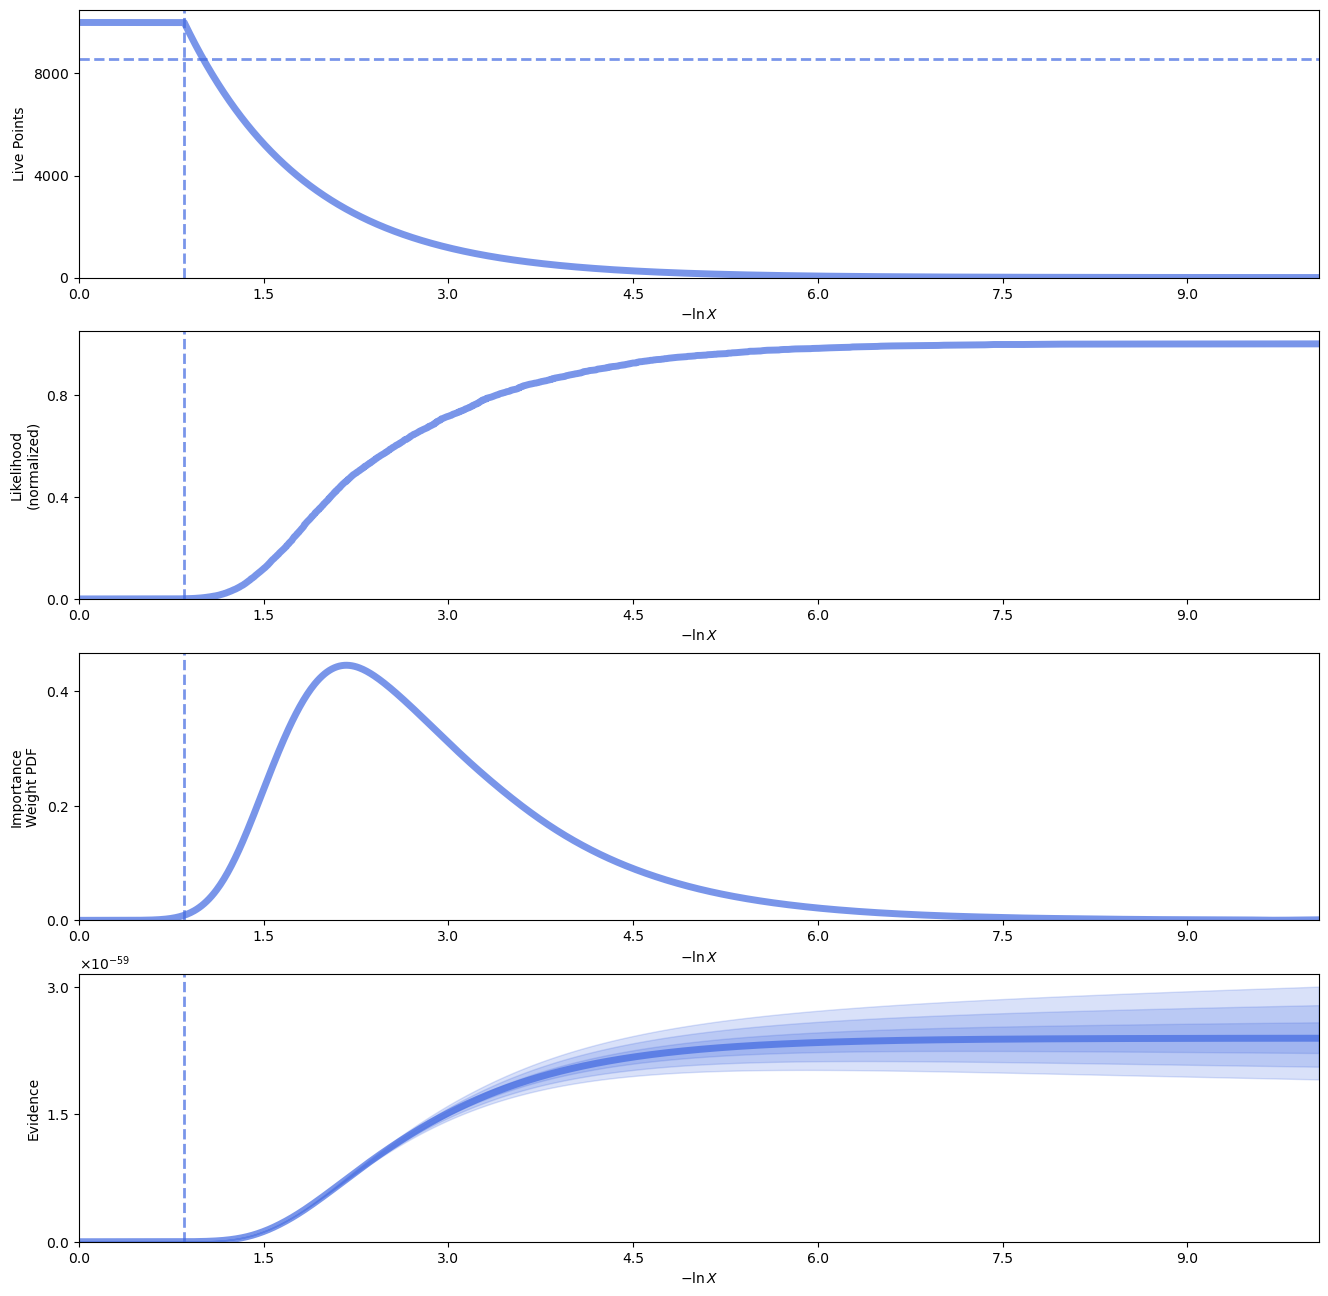

In [19]:
#Runplot
rfig, raxes = dyplot.runplot(sresults, color = 'royalblue')

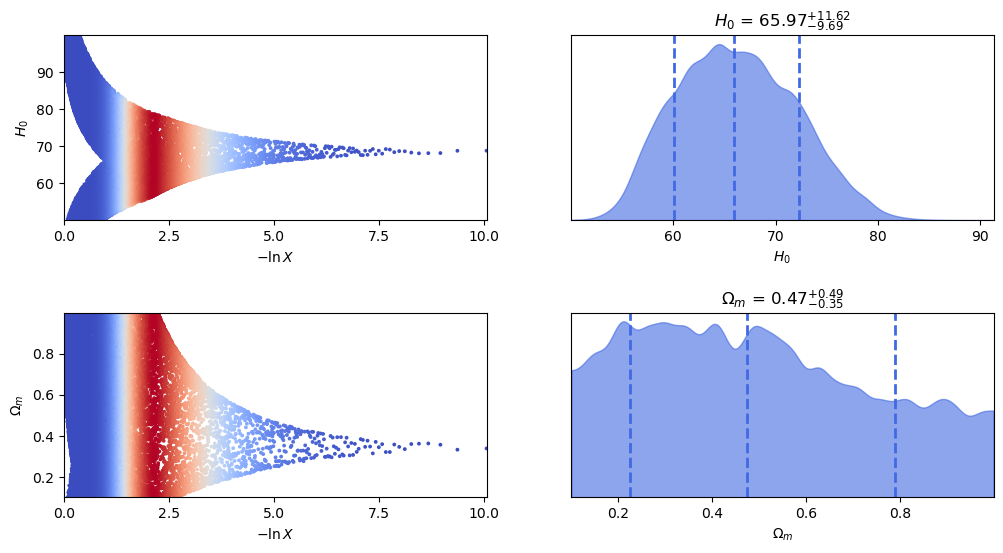

In [20]:
#Traceplot
tfig, taxes = dyplot.traceplot(sresults, labels = labels, post_color='royalblue', trace_cmap='coolwarm', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

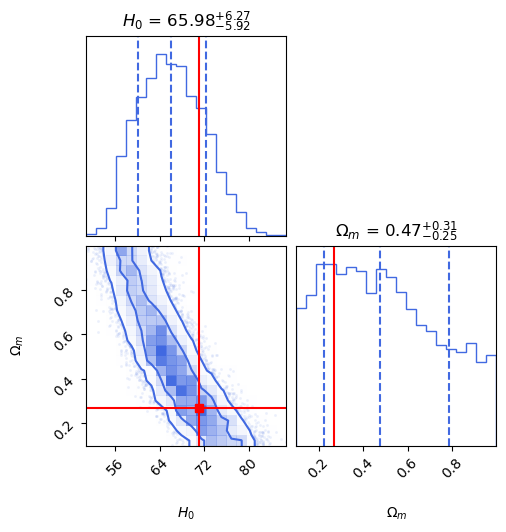

In [21]:
#Corner plot
samples_nested = sresults.samples 
weights = np.exp(sresults.logwt - sresults.logz[-1])  #The samples tha dynesty gives are weighted so we have to reweight them
samples_nested_equal = dyfunc.resample_equal(samples_nested, weights)
corner.corner(samples_nested_equal, labels=labels, levels=[0.68,0.95], show_titles=True, quantiles=[0.16, 0.5, 0.84], color = 'royalblue', truths=[71, 0.27], truth_color='red');

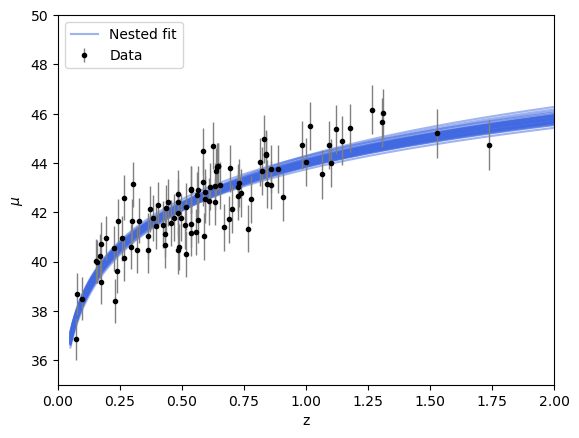

In [22]:
#Fitting our data using different values of parameters
theta_nested = samples_nested_equal[::500, :]
for i in range(len(theta_nested[:, 0])):
    if i==0:
        plt.plot(z_grid, model(z_grid, theta_nested[i, :]), color = 'royalblue', alpha=0.5, label = 'Nested fit')
    else:
        plt.plot(z_grid, model(z_grid, theta_nested[i, :]), color = 'royalblue', alpha=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Parametric fit with $\Omega_m$ = 1

In [23]:
def model_nodark(z, theta):
    H = float(theta)
    cosmological = LambdaCDM(H0 = H, Om0 = 1, Ode0= 0)
    return cosmological.distmod(z).value

In [24]:
def LogLikelihood_nested_nodark(theta, z, mu):
    mu_fit = model_nodark(z, theta)
    return np.sum(scipy.stats.norm(loc=mu_fit, scale=dmu).logpdf(mu)) 

def Prior_nested_nodark(u):
    param = np.copy(u)
    param[0] = scipy.stats.uniform.ppf(u[0], loc = H_min, scale = H_max-H_min)
    return param

In [25]:
nested_nodark = dynesty.NestedSampler(LogLikelihood_nested_nodark, Prior_nested_nodark, 1,  #Defining the sampler
                                      logl_args=[z_sample, mu_sample], nlive = 10000)
nested_nodark.run_nested()  #Running the sampler
sresults_nodark = nested_nodark.results

C:\Users\restu\AppData\Local\Temp\ipykernel_19480\2820737599.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H = float(theta)
10384it [00:47, 220.65it/s, +10000 | bound: 0 | nc: 1 | ncall: 38361 | eff(%): 71.873 | loglstar:   -inf < -133.530 <    inf | logz: -135.608 +/-    nan | dlogz:  0.000 > 10.009]


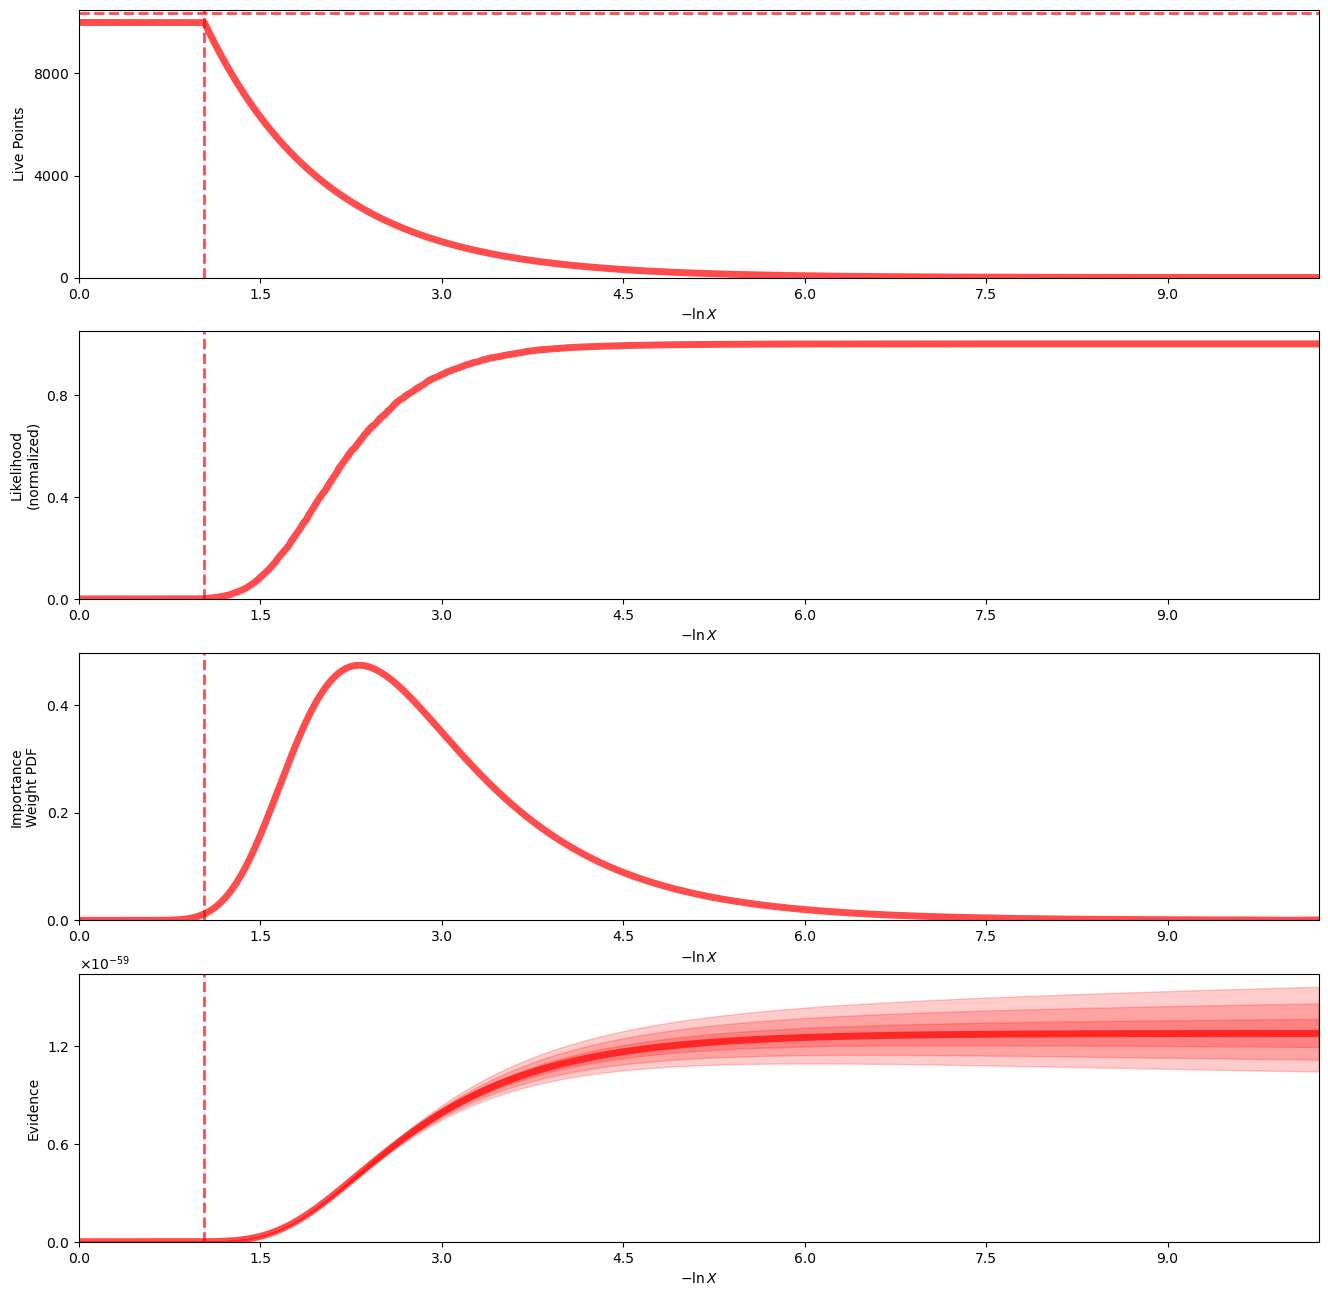

In [26]:
#Runplot
rfig_nodark, raxes_nodark = dyplot.runplot(sresults_nodark, color = 'red')

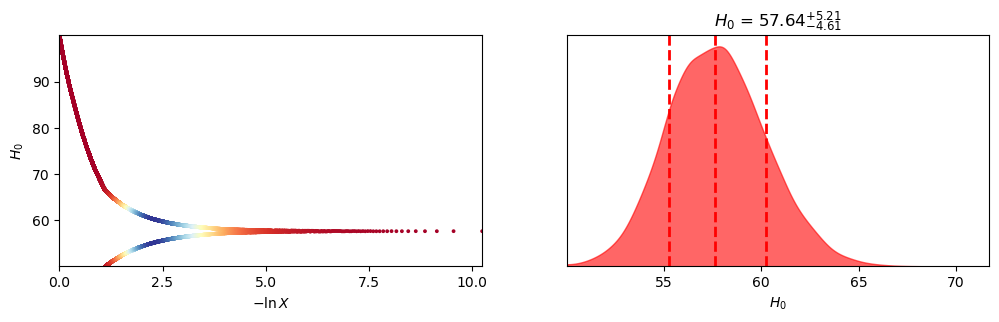

In [27]:
#Traceplot
label = [r'$H_0$']
tfig_nodark, taxes_nodark = dyplot.traceplot(sresults_nodark, labels = label, post_color='red', trace_cmap='RdYlBu', show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.subplots_adjust(hspace=0.5)

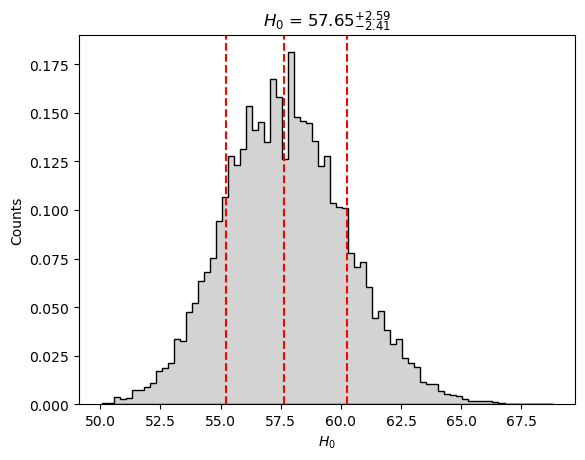

In [28]:
samples_nodark = sresults_nodark.samples 
weights_nodark = np.exp(sresults_nodark.logwt - sresults_nodark.logz[-1])
samples_nodark_equal = dyfunc.resample_equal(samples_nodark, weights_nodark)

median = np.median(samples_nodark_equal)  #Computing the median
perc = np.percentile(samples_nodark_equal, [16, 50, 84])  #Computing the percentile
q = np.diff(perc)

#Histogram of H_0
fancyhist(samples_nodark_equal, bins="freedman", density=True, ec='black', fc='lightgrey', histtype='stepfilled')
plt.title(r'%s = $%0.2f^{+%0.2f}_{-%0.2f}$' %(labels[0], median, q[1], q[0]))
plt.axvline(perc[0], color = 'red', ls = '--')
plt.axvline(perc[1], color = 'red', ls = '--')
plt.axvline(perc[2], color = 'red', ls = '--')
plt.xlabel(labels[0])
plt.ylabel('Counts')
plt.show()

In [29]:
print('Dark energy model:')
sresults.summary()
print('\nNo dark energy model:')
sresults_nodark.summary()

Dark energy model:
Summary
nlive: 10000
niter: 8559
ncall: 23477
eff(%): 79.052
logz: -134.978 +/-  0.075

No dark energy model:
Summary
nlive: 10000
niter: 10384
ncall: 28361
eff(%): 71.873
logz: -135.608 +/-  0.068


In [30]:
print('The logarithmic Bayes factor is: ', np.log(np.exp(sresults.logz[-1])/np.exp(sresults_nodark.logz[-1])))

The logarithmic Bayes factor is:  0.6297689194272493


According to the Jeffreys Scale the evidence is “not worth more than a bare mention”. So we are not able to choose a model between the two.
We can try to use the Savage-Dickey density ratio, that is more appropriate for this type of problem.

## Savage-Dickey density ratio

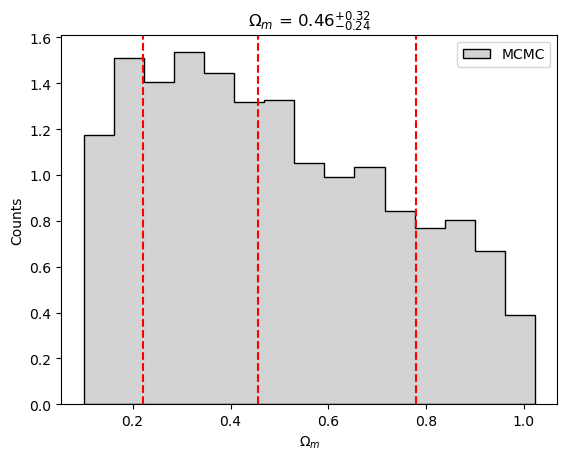

In [31]:
median_om = np.median(burned_trace[:,1])  #Median of omega_m using the result of emcee
perc_om = np.percentile(burned_trace[:,1], [16, 50, 84])  #Percentile of omega_m using the result of emcee
q_om = np.diff(perc_om)

#Histogram of omega_m using the result of emcee
fancyhist(burned_trace[:,1], bins="freedman", density=True, ec='black', fc='lightgrey', histtype='stepfilled', label='MCMC')
plt.title(r'%s = $%0.2f^{+%0.2f}_{-%0.2f}$' %(labels[1], median_om, q_om[1], q_om[0]))
plt.axvline(perc_om[0], color = 'red', ls = '--')
plt.axvline(perc_om[1], color = 'red', ls = '--')
plt.axvline(perc_om[2], color = 'red', ls = '--')
plt.xlabel(labels[1])
plt.ylabel('Counts')
plt.legend()
plt.show()

Now I want to find the marginalized posterior distribution of $\Omega_m$ using KDE.

In [49]:
o_grid = np.linspace(0.1, 1, 10000) 
kde_skl = KernelDensity(bandwidth = 0.1, kernel = 'gaussian')
kde_skl.fit(burned_trace[:,1][:, np.newaxis])
log_pdf = kde_skl.score_samples(o_grid[:, np.newaxis])
pdf = np.exp(log_pdf)

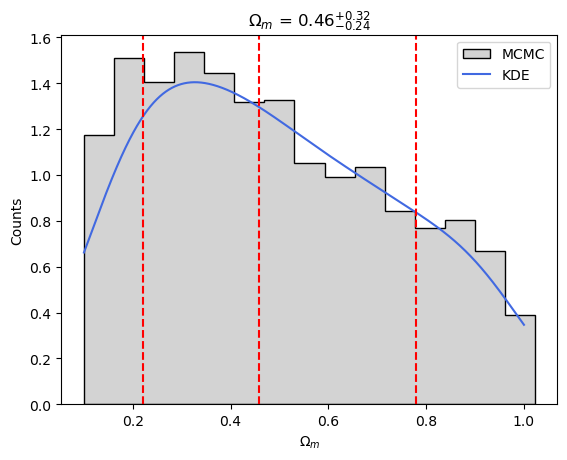

In [50]:
fancyhist(burned_trace[:,1], bins="freedman", density=True, ec='black', fc='lightgrey', histtype='stepfilled', label='MCMC')
plt.title(r'%s = $%0.2f^{+%0.2f}_{-%0.2f}$' %(labels[1], median_om, q_om[1], q_om[0]))
plt.plot(o_grid, pdf, color = 'royalblue', label = 'KDE')
plt.axvline(perc_om[0], color = 'red', ls = '--')
plt.axvline(perc_om[1], color = 'red', ls = '--')
plt.axvline(perc_om[2], color = 'red', ls = '--')
plt.xlabel(labels[1])
plt.ylabel('Counts')
plt.legend()
plt.show()

In [52]:
SDR = np.log((1/(omega_max-omega_min))/pdf[o_grid==1])
print('The logarithmic bayes factor is', SDR[0])

The logarithmic Savage-Dickey ratio is 1.1643237622409024


This means that, according to the Jeffrey scale, there is a weak evidence that the narrow model is preffered to the broader model. This is still not enough to affirm that the model with $\Omega_m = 1$ is the correct one, because the bayes factor is still too small.

## Cloning data

At first I have to clone the redshift. To do so, I sample new data from the distribution of $z$ that I compute using KDE.
Then I have to find the corresponding values of $\mu$ using GPR or Nested Sampling.

In [35]:
#Use CV to find the best bendwidth
bwrange_z = np.linspace(0.01, 1, 1000)
k = 5
grid_z = GridSearchCV(KernelDensity(), {'bandwidth': bwrange_z}, cv= k)
grid_z.fit(z_sample[:, np.newaxis])
best_bw_z = grid_z.best_params_['bandwidth']
print(best_bw_z)

0.13585585585585588


In [36]:
#KDE
kde_z = KernelDensity(bandwidth = best_bw_z, kernel = 'gaussian')
kde_z.fit(z_sample[:, np.newaxis])
log_pdf_z = kde_z.score_samples(z_grid[:, np.newaxis])
pdf_z = np.exp(log_pdf_z)

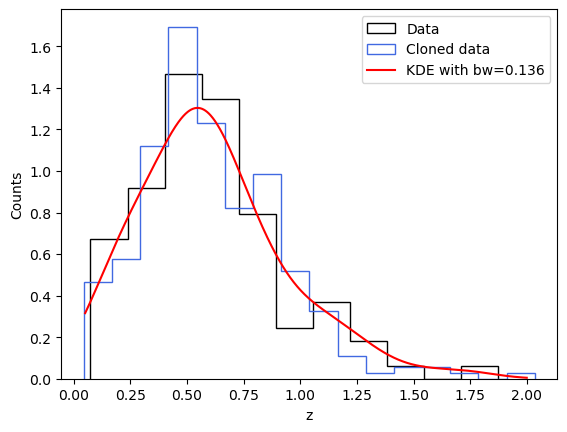

In [37]:
z_clone = kde_z.sample(300).ravel()  #Sampling from the distribution
z_clone = z_clone[z_clone>0]

fancyhist(z_sample, bins="freedman", density=True, ec='black', histtype='step', label='Data')
fancyhist(z_clone, bins="freedman", density=True, ec='royalblue', histtype='step', label='Cloned data')
plt.plot(z_grid, pdf_z, color = 'red', label = 'KDE with bw=%0.3f' %best_bw_z)
plt.xlabel('z')
plt.ylabel('Counts')
plt.legend()
plt.show()

#### GPR

In [38]:
#Finding the corresponding mu using GPR
mu_gpr=[]
for z in z_clone:
    mu_fit, sigma = gp.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))

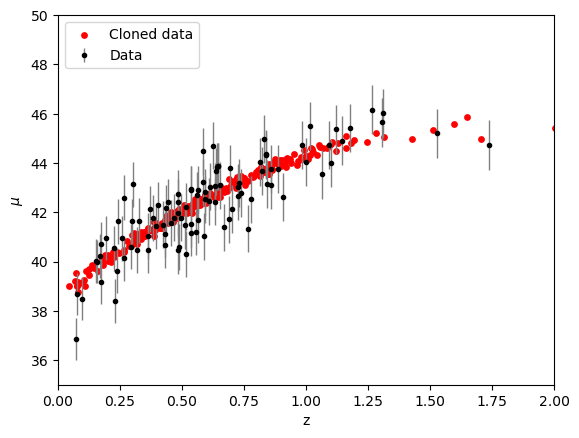

In [39]:
#Plotting the results
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.scatter(z_clone, mu_gpr, color = 'red', label='Cloned data', s=15)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

#### Nested Sampling

In [40]:
#Finding the corresponding mu using Nested Sampling
mu_nested=[]
for z in z_clone:
    param = samples_nested_equal[np.random.choice(samples_nested_equal.shape[0])]
    mu_nested.append(model(z, param))

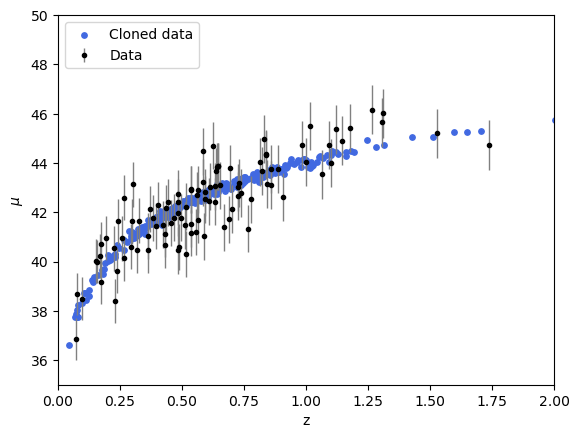

In [41]:
#Plotting the results
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='Data')
plt.scatter(z_clone, mu_nested, color = 'royalblue', label='Cloned data', s=15)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()